In [1]:
import os
import cv2
from tqdm import tqdm
import albumentations as A
from PIL import Image
import numpy as np
from pathlib import Path

input_dir = Path("/kaggle/input/fishes/Fishes")
output_dir = Path("/kaggle/working/augmented")
output_dir.mkdir(exist_ok=True)

transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.5),
    A.GaussianBlur(p=0.3),
    A.RandomCrop(width=200, height=200, p=0.5),
    A.HueSaturationValue(p=0.3),
    A.GaussNoise(p=0.3),
])

for cls in os.listdir(input_dir):
    cls_path = input_dir / cls
    if not cls_path.is_dir():
        continue
    
    (output_dir / cls).mkdir(exist_ok=True)

    images = list(cls_path.glob("*.*"))
    
    for img_path in tqdm(images, desc=f"Augmenting {cls}"):
        img = cv2.imread(str(img_path))[:,:,::-1]
        
        # 5 augmentations per image
        for i in range(10):
            aug = transform(image=img)['image']
            aug = cv2.cvtColor(aug, cv2.COLOR_RGB2BGR)

            save_name = f"{img_path.stem}_aug_{i}.jpg"
            cv2.imwrite(str(output_dir/cls/save_name), aug)

print("DONE!")

Augmenting Croaker(Poya): 100%|██████████| 11/11 [00:25<00:00,  2.32s/it]

DONE!


In [2]:
aug_count = sum(len(files) for _,_,files in os.walk(output_dir))
print("TOTAL AUGMENTED IMAGES =", aug_count)

TOTAL AUGMENTED IMAGES = 5830


In [5]:
import os
from pathlib import Path
from PIL import Image
from tqdm import tqdm

SRC = Path("/kaggle/working/augmented")
DST = Path("/kaggle/working/Fishes_resized")
DST.mkdir(parents=True, exist_ok=True)

TARGET_SIZE = (256, 256)   # যেকোনো সাইজ রাখতে পারবেন

for cls in sorted([d.name for d in SRC.iterdir() if d.is_dir()]):
    (DST/cls).mkdir(exist_ok=True)
    for img_path in tqdm(list((SRC/cls).glob("*.*")), desc=cls):
        try:
            img = Image.open(img_path).convert("RGB")
            img = img.resize(TARGET_SIZE, Image.BILINEAR)
            img.save(DST/cls/img_path.name)
        except:
            pass

print("DONE — All images resized!")

shrimp: 100%|██████████| 260/260 [00:14<00:00, 17.89it/s]

DONE — All images resized!


In [6]:
import os
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [7]:
import os
import time
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve
from sklearn.preprocessing import label_binarize

In [8]:
train_tf = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor()
])

test_tf = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor()
])

In [9]:
data_root = "/kaggle/working/Fishes_resized"

full_dataset = datasets.ImageFolder(data_root, transform=train_tf)
class_names = full_dataset.classes
num_classes = len(class_names)

len(full_dataset), num_classes

(5830, 21)

In [10]:
val_size = int(0.2 * len(full_dataset))
train_size = len(full_dataset) - val_size

train_ds, val_ds = random_split(full_dataset, [train_size, val_size])

# validationের tf ঠিক করা
val_ds.dataset.transform = test_tf

In [11]:
train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=32, shuffle=False)

In [12]:
model = models.resnet50(weights="IMAGENET1K_V2")
model.fc = nn.Linear(model.fc.in_features, num_classes)
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [13]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

In [14]:
num_epochs = 50
best_val_loss = np.inf
patience = 5
wait = 0

train_losses, val_losses = [], []
train_accs, val_accs = [], []

train_start = time.time()  # timing
for epoch in range(num_epochs):

    # TRAIN ------------------------
    model.train()
    running_loss, correct, total = 0, 0, 0

    for imgs, labels in train_loader:
        imgs, labels = imgs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, pred = torch.max(outputs, 1)
        correct += (pred == labels).sum().item()
        total += labels.size(0)

    train_loss = running_loss / len(train_loader)
    train_acc = correct / total

    # VAL ---------------------------
    model.eval()
    v_loss, v_correct, v_total = 0, 0, 0

    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs, labels = imgs.to(device), labels.to(device)

            outputs = model(imgs)
            loss = criterion(outputs, labels)

            v_loss += loss.item()
            _, pred = torch.max(outputs, 1)
            v_correct += (pred == labels).sum().item()
            v_total += labels.size(0)

    val_loss = v_loss / len(val_loader)
    val_acc = v_correct / v_total

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)

    print(f"Epoch {epoch+1}/{num_epochs} | "
          f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | "
          f"Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}")

Epoch 1/50 | Train Loss: 1.8483 | Val Loss: 1.3380 | Train Acc: 0.4880 | Val Acc: 0.5789
Epoch 2/50 | Train Loss: 1.1229 | Val Loss: 1.1783 | Train Acc: 0.6464 | Val Acc: 0.6218
Epoch 3/50 | Train Loss: 0.8992 | Val Loss: 1.1785 | Train Acc: 0.7108 | Val Acc: 0.6209
Epoch 4/50 | Train Loss: 0.7216 | Val Loss: 1.1538 | Train Acc: 0.7684 | Val Acc: 0.6432
Epoch 5/50 | Train Loss: 0.5611 | Val Loss: 1.1982 | Train Acc: 0.8255 | Val Acc: 0.6484
Epoch 6/50 | Train Loss: 0.4359 | Val Loss: 1.3437 | Train Acc: 0.8647 | Val Acc: 0.6304
Epoch 7/50 | Train Loss: 0.3270 | Val Loss: 1.3066 | Train Acc: 0.8994 | Val Acc: 0.6501
Epoch 8/50 | Train Loss: 0.2571 | Val Loss: 1.3815 | Train Acc: 0.9224 | Val Acc: 0.6415
Epoch 9/50 | Train Loss: 0.1822 | Val Loss: 1.5098 | Train Acc: 0.9438 | Val Acc: 0.6278
Epoch 10/50 | Train Loss: 0.1417 | Val Loss: 1.4877 | Train Acc: 0.9599 | Val Acc: 0.6364
Epoch 11/50 | Train Loss: 0.1146 | Val Loss: 1.5738 | Train Acc: 0.9685 | Val Acc: 0.6449
Epoch 12/50 | Train

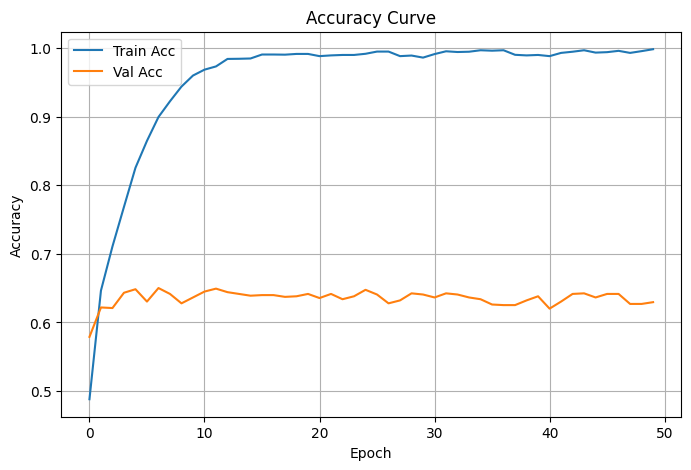

In [15]:
plt.figure(figsize=(8,5))
plt.plot(train_accs, label="Train Acc")
plt.plot(val_accs, label="Val Acc")
plt.title("Accuracy Curve")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid(True)
plt.legend()
plt.show()

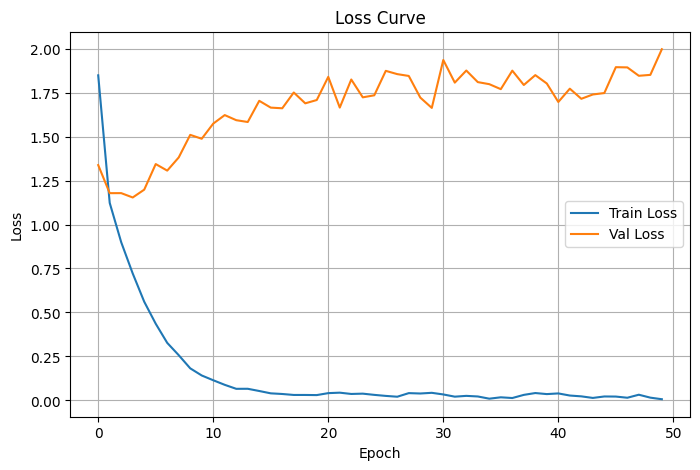

In [16]:
plt.figure(figsize=(8,5))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.title("Loss Curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.legend()
plt.show()

In [17]:
test_loader = DataLoader(full_dataset, batch_size=32, shuffle=False)  # if you have separate test set, use it

model.eval()
all_labels = []
all_preds = []
all_probs = []

test_start = time.time()
with torch.no_grad():
    for imgs, labels in test_loader:
        imgs, labels = imgs.to(device), labels.to(device)

        outputs = model(imgs)
        probs = torch.softmax(outputs, dim=1)

        _, pred = torch.max(outputs, 1)

        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(pred.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())

test_end = time.time()
print(f"Testing Wall-clock Time: {test_end - test_start:.2f} sec")

Testing Wall-clock Time: 26.99 sec


In [18]:
all_labels = np.array(all_labels)
all_preds = np.array(all_preds)

overall_acc = (all_labels == all_preds).mean()
print("Overall Accuracy:", overall_acc)

per_class_acc = {}
for i, c in enumerate(class_names):
    idx = (all_labels == i)
    per_class_acc[c] = (all_preds[idx] == i).mean()

per_class_acc

Overall Accuracy: 0.9236706689536878


{'Baim': 0.9088235294117647,
 'Bata': 0.9461538461538461,
 'Batasio(tenra)': 0.90625,
 'Chitul': 0.9836734693877551,
 'Croaker(Poya)': 0.9454545454545454,
 'Hilsha': 0.9222222222222223,
 'Kajoli': 0.9,
 'Meni': 0.8935483870967742,
 'Pabda': 0.8953488372093024,
 'Poli': 0.9235294117647059,
 'Puti': 0.925,
 'Rita': 0.9230769230769231,
 'Rui': 0.9526315789473684,
 'Rupchada': 0.90625,
 'Silver Carp': 0.9142857142857143,
 'Telapiya': 0.9173913043478261,
 'carp': 0.9481481481481482,
 'k': 0.9,
 'kaikka': 0.92,
 'koral': 0.9277777777777778,
 'shrimp': 0.9615384615384616}

In [19]:
print(classification_report(
    all_labels,
    all_preds,
    target_names=class_names,
    digits=4
))

                precision    recall  f1-score   support

          Baim     0.9392    0.9088    0.9238       340
          Bata     0.9354    0.9462    0.9407       260
Batasio(tenra)     0.8896    0.9062    0.8978       320
        Chitul     0.9777    0.9837    0.9807       490
 Croaker(Poya)     0.9720    0.9455    0.9585       110
        Hilsha     0.9055    0.9222    0.9138       270
        Kajoli     0.9536    0.9000    0.9260       480
          Meni     0.7892    0.8935    0.8381       310
         Pabda     0.9413    0.8953    0.9178       430
          Poli     0.9128    0.9235    0.9181       170
          Puti     0.9184    0.9250    0.9217       280
          Rita     0.9231    0.9231    0.9231       130
           Rui     0.9577    0.9526    0.9551       190
      Rupchada     0.9295    0.9062    0.9177       160
   Silver Carp     0.9481    0.9143    0.9309       140
      Telapiya     0.9134    0.9174    0.9154       230
          carp     0.9110    0.9481    0.9292  

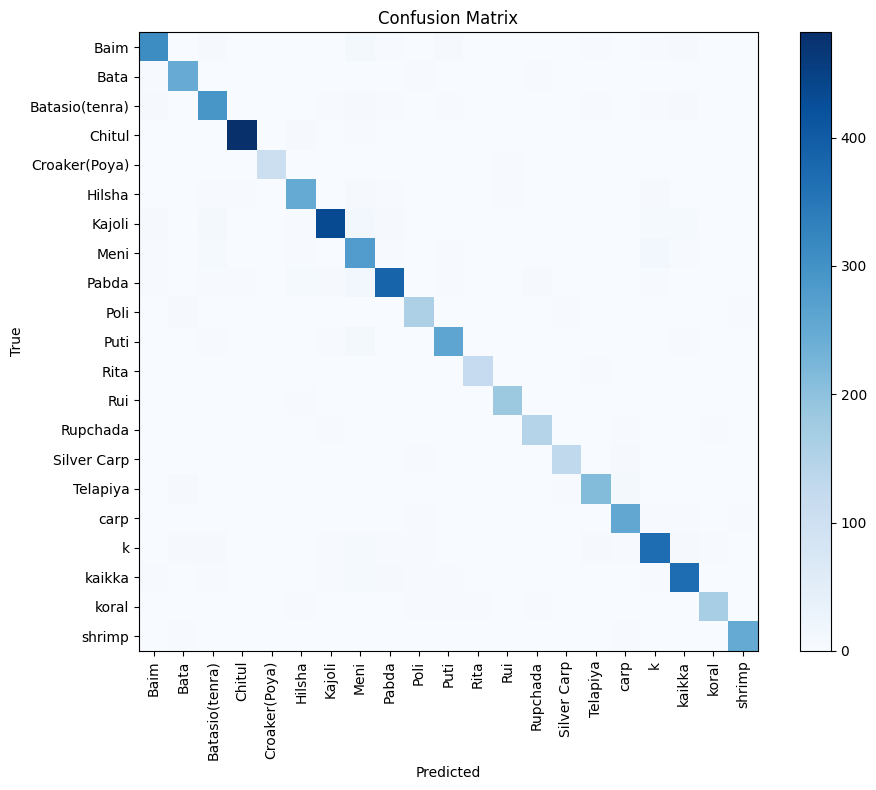

In [20]:
cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(10,8))
plt.imshow(cm, cmap="Blues")
plt.title("Confusion Matrix")
plt.colorbar()
plt.xticks(np.arange(len(class_names)), class_names, rotation=90)
plt.yticks(np.arange(len(class_names)), class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()

In [21]:
y_true_bin = label_binarize(all_labels, classes=list(range(num_classes)))
y_prob = np.array(all_probs)

macro_auc = roc_auc_score(y_true_bin, y_prob, average="macro", multi_class="ovr")
print("Macro ROC–AUC:", macro_auc)

Macro ROC–AUC: 0.996933424878058


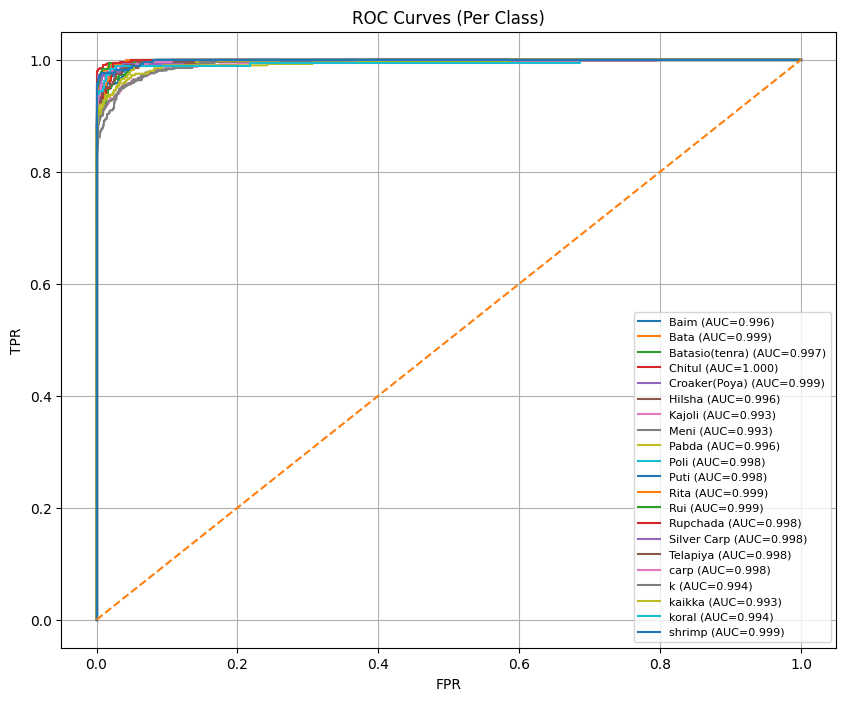

In [22]:
plt.figure(figsize=(10,8))

for i, cls in enumerate(class_names):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_prob[:, i])
    auc_val = roc_auc_score(y_true_bin[:, i], y_prob[:, i])
    plt.plot(fpr, tpr, label=f"{cls} (AUC={auc_val:.3f})")

plt.plot([0,1],[0,1],'--')
plt.title("ROC Curves (Per Class)")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.grid(True)
plt.legend(fontsize=8)
plt.show()

In [23]:
!pip install thop
from thop import profile

dummy = torch.randn(1,3,224,224).to(device)
flops, params = profile(model, inputs=(dummy,))

print(f"GFLOPs per inference: {flops/1e9:.3f}")
print(f"Parameters (M): {params/1e6:.2f}")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 5.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 88.1 MB/s eta 0:00:00:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 65.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 58.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 8.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 35.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 14.6 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 73.9 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5

In [24]:
cm = confusion_matrix(all_labels, all_preds)
np.fill_diagonal(cm, 0)

flat = cm.flatten()
idx = flat.argsort()[-5:][::-1]

print("Top Confused Class Pairs:")
for i in idx:
    r = i // num_classes
    c = i % num_classes
    print(f"{class_names[r]} → {class_names[c]} | Count = {cm[r,c]}")

Top Confused Class Pairs:
Pabda → Meni | Count = 15
Meni → k | Count = 13
Kajoli → Meni | Count = 12
Puti → Meni | Count = 10
Baim → Meni | Count = 9
